In [2]:
import sys 
sys.path.append("..")

from src.feature_extraction.bag_of_words import bag_of_words
from src.preprocess.data_prep_offenseval import DataPrepOffensEval

In [55]:
# Get the training data
english_train_file_path = "../data/raw/OffensEval2019/start-kit/training-v1/offenseval-training-v1.tsv"
dp = DataPrepOffensEval()
result_tuple = dp.get_X_and_ys(file_path=english_train_file_path)
X_original = result_tuple[0]
y_sub_a = result_tuple[1]

In [56]:
print(X_original)

['@USER She should ask a few native Americans what their take on this is.'
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL'
 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT'
 ... "@USER And why report this garbage.  We don't give a crap."
 '@USER Pussy'
 '#Spanishrevenge vs. #justice #HumanRights and #FreedomOfExpression #Spain is a  #fakedemocracy @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER #cddr #shameonSpain #WakeupEurope @USER URL']


In [57]:
print(y_sub_a)

[1 1 0 ... 1 1 0]


In [59]:
# Create train, validation and test sets:
import pandas as pd
X_train, X_test, y_train, y_test = dp.train_test_split(X_original, y_sub_a, test_size=0.2)
X_train, X_val, y_train, y_val = dp.train_test_split(X_train, y_train, test_size=0.1)
print(X_train)

['@USER @USER @USER Please can I have some of whatever it is you’ve been smoking?  Thats some top quality shit you’re coming out with.'
 "@USER @USER @USER @USER @USER Liberals Don't Appreciate Your Sarcasm. They Thought You Were On Their Side."
 '@USER @USER @USER 🇺🇸 BECAUSE THey think Sen Collins is A STUPID COWARD   &amp;all they have to do is Bullie   SenCollins  This is what🇺🇸Conservatives Have lives with For 9️⃣yrs now   Please Vote For Kavanaugh  LetGod Take Care Of the Rest'
 ... '@USER @USER  was spreading #FakeNews about @USER FYI. #MAGA'
 '@USER Holy shit I love her???'
 '@USER Sorry to read this. You’re doing the right thing to report it and warn us all about them. Needless to say you are none of the things they say. Stay strong.']


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
import string
LANG = "english"
MAX_FEATURES = 2000 # Only take into account the top 2k most frequent words
stop_words = list(set(stopwords.words(LANG)))
stop_words.extend(list(string.punctuation))
text_clf = Pipeline([
    ('vect', CountVectorizer(
        stop_words=stop_words,
        max_df=1.0, 
        min_df=0.0,
        max_features=MAX_FEATURES,
    )),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(X_train, y_train)

In [64]:
import numpy as np
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7594410876132931

In [68]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([
    ('vect', CountVectorizer(
        stop_words=stop_words,
        max_df=1.0, 
        min_df=0.0,
        max_features=MAX_FEATURES,
    )),
    ('tfidf', TfidfTransformer()),
    ('clf-svm', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-3,
        n_iter=10,
        random_state=42,
    )),
])

text_clf_svm.fit(X_train, y_train)

/Users/gudbjartursigurbergsson/PythonEnv/thesis/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=["shan't"...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [69]:
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == y_test)

0.7262084592145015

In [75]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
}

In [77]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

/Users/gudbjartursigurbergsson/PythonEnv/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/gudbjartursigurbergsson/PythonEnv/thesis/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [78]:
gs_clf.best_score_
gs_clf.best_params_

{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [79]:
pred_gs_svm = gs_clf.predict(X_test)
np.mean(pred_gs_svm == y_test)

0.7265861027190332

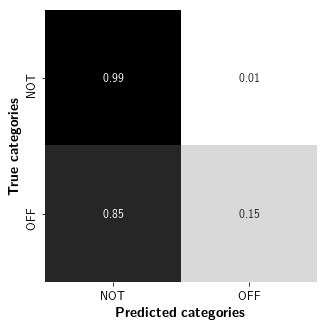

In [81]:
from src.classifiers.classifier_baseline import BaselineClassifier
c = BaselineClassifier(1, 1, 1, 1, 1, 1, 1, 1, 1, 'pass', 'test')
conf_df = c.confusion_matrix(y_test, pred_gs_svm, 2, ["NOT", "OFF"])
c.plot_confusion_matrix(conf_df)

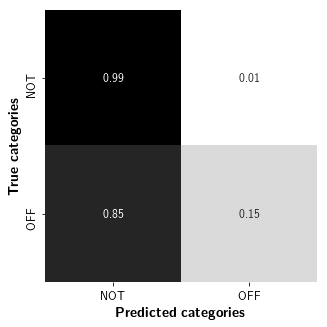

In [83]:
conf_df = c.confusion_matrix(y_test, predicted_svm, 2, ["NOT", "OFF"])
c.plot_confusion_matrix(conf_df)

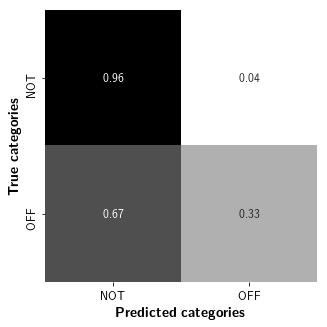

In [84]:
conf_df = c.confusion_matrix(y_test, predicted, 2, ["NOT", "OFF"])
c.plot_confusion_matrix(conf_df`)